# Interacting with a small-strain MFront behaviour

*Author: Jeremy Bleyer, ENPC*

## Objectives 

This notebook shows how we can use the Python [`MFrontGenericSupportInterface`](https://thelfer.github.io/mgis/web/index.html) to interact with a small-strain mechanical behaviour compiled with MFront.

The corresponding behaviour is a small-strain von Mises plasticity model with non-linear isotropic hardening and is implemented in the `SmallStrainPlasticity.mfront` file using the [`StandardElastoViscoPlasticity` brick](https://thelfer.github.io/tfel/web/StandardElastoViscoPlasticityBrick.html). Some material parameters (elastic parameters) are hard-coded in the file while others (plastic parameters) are declared as material properties to be specified by the user.

The following implementation shows:
- how to read information from the compiled behaviour, such as the declared internal state variable names or material properties
- how to set up material properties
- how to impose values for the total strain, call the behaviour integration for a batch of quadrature points and update the mechanical state for subsequent time steps
- how to locally solve a non-linear system involving the computed tangent operator

## Problem setting

Regarding the final point, we aim to solve for a uniaxial stress state along the $x$ direction, while controlling the imposed horizontal strain $\epsilon$. The remaining components $\varepsilon_{ij}$ are considered as unknowns and we want to solve the following problem at a given imposed horizontal strain: Find $\boldsymbol{\varepsilon}$ such that
$$
\boldsymbol{R}(\boldsymbol{\varepsilon}) = \begin{Bmatrix}
\varepsilon_{xx} - \epsilon \\
\sigma_{yy}(\boldsymbol{\varepsilon}) \\
\sigma_{zz}(\boldsymbol{\varepsilon}) \\
\sigma_{xy}(\boldsymbol{\varepsilon}) \\
\sigma_{xz}(\boldsymbol{\varepsilon}) \\
\sigma_{yz}(\boldsymbol{\varepsilon})
\end{Bmatrix} = 0
$$

To solve this non-linear problem, we write a custom Newton-Raphson method which will involve the following jacobian:
$$
\boldsymbol{J} = \dfrac{\partial \boldsymbol{R}}{\partial \boldsymbol{\varepsilon}} = \begin{bmatrix} 
\begin{bmatrix} 1 & 0 & \ldots & 0\end{bmatrix}\\
\bar{C}_\text{tang}
\end{bmatrix}
$$
where $\bar{\boldsymbol{C}}_\text{tang}$ is the sub-matrix obtained by removing the first row from the tangent stiffness $\boldsymbol{C}_\text{tang} = \dfrac{\partial \boldsymbol{\sigma}}{\partial \boldsymbol{\varepsilon}}$.

In the following, we will compute the behaviour integration and the above non-linear resolution for a batch of `ngauss` points for illustration purposes. For simplicity, we will impose the same strain $\epsilon$ for all points, yielding the same response for all points but different strain values could also be considered for the different material points.

## Implementation

### Compiling the behaviour

First, we call the `mfront --obuild --interface=generic SmallStrainPlasticity.mfront` command to compile the MFront behaviour. This should only be done once and for all if the behaviour implementation does not change anymore.

Shared libraries are then stored in the `src/libBehaviour.so` file which will be used to load the behaviour.

In [1]:
import subprocess
import numpy as np
import mgis.behaviour as mgis_bv

behaviour_name = "SmallStrainPlasticity"
subprocess.call(["mfront", "--obuild", "--interface=generic", behaviour_name+".mfront"]);

lib_path = "src/libBehaviour.so"

Treating target : all
The following library has been built :
- libBehaviour.so :  LogarithmicStrainPlasticity_AxisymmetricalGeneralisedPlaneStrain LogarithmicStrainPlasticity_Axisymmetrical LogarithmicStrainPlasticity_PlaneStrain LogarithmicStrainPlasticity_GeneralisedPlaneStrain LogarithmicStrainPlasticity_Tridimensional SmallStrainPlasticity_AxisymmetricalGeneralisedPlaneStrain SmallStrainPlasticity_Axisymmetrical SmallStrainPlasticity_PlaneStrain SmallStrainPlasticity_GeneralisedPlaneStrain SmallStrainPlasticity_Tridimensional


### Loading the behaviour

We first need to choose the modeling hypothesis. Here, we will work with 3D states and thus choose the `Tridimensional` hypothesis. Behaviours are loaded differently depending on whether we work with a small or finite-strain setting. We use the `isStandardFiniteStrainBehaviour` function to check whether the behaviour is finite strain or not. The finite-strain case is described in another demo.

In [2]:
hypothesis = mgis_bv.Hypothesis.Tridimensional

is_finite_strain = mgis_bv.isStandardFiniteStrainBehaviour(lib_path, behaviour_name)
if is_finite_strain:
    print("Finite strain behaviour detected.")
    bopts = mgis_bv.FiniteStrainBehaviourOptions()
    bopts.stress_measure = mgis_bv.FiniteStrainBehaviourOptionsStressMeasure.PK2
    bopts.tangent_operator = (
        mgis_bv.FiniteStrainBehaviourOptionsTangentOperator.DPK1_DF
    )
    behaviour = mgis_bv.load(bopts, lib_path, behaviour_name, hypothesis)
else:
    print("Small strain behaviour detected.")
    behaviour = mgis_bv.load(lib_path, behaviour_name, hypothesis)

Small strain behaviour detected.


The `Behaviour` object now contains several information about the behaviour implementation such as names and types of gradients and thermodynamic forces and external or internal state variables. Here, we work with a purely mechanical behaviour so that gradients consist only of the total strain `Strain`. The resulting thermodynamic stress is `Stress`. By default, `Temperature` is always declared as an external state variable by MFront. Finally, since we are dealing with an elastoplastic behaviour with isotropic hardening, the internal state variables are the `ElasticStrain` and the `EquivalentPlasticStrain`. The former is a symmetric tensor whereas the latter is only a scalar.

In [ ]:
print("Kinematic type:", behaviour.getKinematic())
print("Gradient names:", [s.name for s in behaviour.gradients])
print("Thermodynamic forces names:", [s.name for s in behaviour.thermodynamic_forces])

print(
    "External state variable names:",
    [s.name for s in behaviour.external_state_variables],
)
print(
    "Internal state variable names:",
    [s.name for s in behaviour.internal_state_variables],
)
print(
    "Internal state variable types:",
    [s.type for s in behaviour.internal_state_variables],
)

Kinematic type: SmallStrainKinematic
Gradient names: ['Strain']
Thermodynamic forces names: ['Stress']
External state variable names: ['Temperature']
Internal state variable names: ['ElasticStrain', 'EquivalentPlasticStrain']
Internal state variable types: [mgis.behaviour.VariableType.STENSOR, mgis.behaviour.VariableType.SCALAR]


The size of these different quantities can be checked. Symmetric tensors in 3D are represented here as arrays of size 6 (using Mandel notation, see [Tensors in MFront](https://thelfer.github.io/tfel/web/tensors.html)).

In [ ]:
for s in behaviour.gradients + behaviour.thermodynamic_forces + behaviour.internal_state_variables: 
    print(f"{s.name} is of size {mgis_bv.getVariableSize(s, hypothesis)}")

Strain is of size 6
Stress is of size 6
ElasticStrain is of size 6
EquivalentPlasticStrain is of size 1


For more complex behaviours, different "blocks" of tangent operators can be declared and computed. The names of the tangent blocks can be retrieved as shown below. Here, we have a simple mechanical behaviour so that the only tangent operator is the tangent stiffness $\boldsymbol{C}_\text{tang} = \dfrac{\partial \boldsymbol{\sigma}}{\partial \boldsymbol{\varepsilon}}$.

In [ ]:
print(
    "Tangent operator block names:",
    [f"d{s[0].name}_d{s[1].name}" for s in behaviour.tangent_operator_blocks],
)

Tangent operator block names: ['dStress_dStrain']


Finally, names of material properties can also be retrieved easily as follows:

In [ ]:
print(
    "Material property names:",
    [s.name for s in behaviour.material_properties],
)

Material property names: ['InitialYieldStress', 'FinalYieldStress', 'HardeningCoefficient']


Other informations such as behaviour material symmetry or predefined parameters can also be obtained as follows:

In [7]:
print(behaviour.symmetry)
print(behaviour.parameters)

Isotropic
['epsilon', 'theta', 'YoungModulus', 'PoissonRatio', 'RelativeValueForTheEquivalentStressLowerBoundDefinition', 'minimal_time_step_scaling_factor', 'maximal_time_step_scaling_factor', 'numerical_jacobian_epsilon']


### Setting up the material data manager

The material data manager will be the data structure which will hold the information about the mechanical state and tangent operator for a single or a batch of integration points during a given time step. We first set up the data manager by declaring the number of integration points we want to handle.

In [8]:
ngauss = 3
data = mgis_bv.MaterialDataManager(behaviour, ngauss)

Values at the beginning of the time step will be stored in `data.s0`. This object is a `StateManager` which holds values of the gradients, thermodynamic forces and internal state variables. A similar one is stored in `data.s1` which will hold values at the end of the current time step, once behaviour integration has been performed. Here, by default, `Strain` is initialized with a zero tensor, as well as all other variables. We see below that `data.s0.gradients` is of shape `ngauss x 6` corresponding to the 6 components of the `ngauss` integration points.

In [9]:
print("Gradients:")
print("  Beginning of time step:\n", data.s0.gradients)
print("  End of time step:\n", data.s1.gradients)

print("Thermodynamic forces:")
print("  Beginning of time step:\n", data.s0.thermodynamic_forces)
print("  End of time step:\n", data.s1.thermodynamic_forces)

Gradients:
  Beginning of time step:
 [[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
  End of time step:
 [[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
Thermodynamic forces:
  Beginning of time step:
 [[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
  End of time step:
 [[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]


Conversely, internal state variables are of shape `ngauss x 7` with components of `ElasticStrain` and `EquivalentPlasticStrain` being concatenated.

In [10]:
print("Internal state variables:")
print("  Beginning of time step:\n", data.s0.internal_state_variables)
print("  End of time step:\n", data.s1.internal_state_variables)

Internal state variables:
  Beginning of time step:
 [[0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]]
  End of time step:
 [[0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]]


### Declare material properties

In order to perform the behaviour integration, we need to declare the values for the material properties which are yet unspecified. We also need to declare the value of the temperature, although it is not used in practice. Note that we can declare different values at the beginning and at the end of the time step, although here we use the same values. Finally, we would also apply different values for the different integration points, if needed.

In [11]:
for state_manager in [data.s0, data.s1]:
    mgis_bv.setMaterialProperty(state_manager, "InitialYieldStress", 250e6)
    mgis_bv.setMaterialProperty(state_manager, "FinalYieldStress", 400e6)
    mgis_bv.setMaterialProperty(state_manager, "HardeningCoefficient", 1000.)

    mgis_bv.setExternalStateVariable(state_manager, "Temperature", 293.15)

### Defining the load-stepping scheme and the nonlinear system 

Below, we will impose a cyclic loading in terms of imposed horizontal strain. The value of the time step `dt` must be provided but is irrelevant here since we are dealing with a rate-independent behaviour.

In [12]:
# strain history
N = 20
eps_max = 3e-3
eps_list = np.concatenate((np.linspace(0, eps_max, N), np.linspace(eps_max, -eps_max, N), np.linspace(-eps_max, 0, N))*2)

dt = 0

We now implement the expression of the global residual $\boldsymbol{R}$ and its jacobian $\boldsymbol{J}$. As stresses are expressed here in Pa, we use a scaling of `1e-9` to scale the stress components to values close to strain values.

In [13]:
stress_scaling = 1e-9
def residual(eps, sig, imposed_eps):
    return np.concatenate((eps[:,[0]]-imposed_eps, sig[:,1:]*stress_scaling), axis=1)
def jacobian(eps, sig, Ct):
    Jac = np.zeros_like(Ct)
    Jac[:,0,0] = 1
    Jac[:,1:,:] = Ct[:,1:,:]*stress_scaling
    return Jac

Integration of the material behaviour will be done by specifying that we want to compute the consistent tangent operator. 
We then implement the time stepping loop and the Newton-Raphson resolution. We recall that the values of the total strain are all assumed to be unknown and will be stored in the `eps` variable, the latter being initialized with the strain values at the beginning of the time step. During a Newton-Raphson iteration, the strain values at the end of the time step are updated with the current value for `eps`. Then, integration is performed using `mgis_bv.integrate`. Next, we retrieve the new value for the stress, stored in `sig` and of the tangent operator, stored in `Ct`. We evaluate the residual $\boldsymbol{R}$ and perform the Newton correction to `eps` by solving the jacobian system. Finally, we report the horizontal stress value at the first integration point (we can check that all `ngauss` points give the same value). Before going to the next load step, the computed state must be updated using `mgis_bv.update(data)` which copies the computed state `s1` into `s0`.

In [14]:
integration_type = mgis_bv.IntegrationType.IntegrationWithConsistentTangentOperator
rtol = 1e-8
atol = 1e-8
niter_max = 20

Sxx = np.zeros_like(eps_list)
for i, eps_imposed in enumerate(eps_list):
    eps = np.copy(data.s0.gradients)
    sig = np.copy(data.s0.thermodynamic_forces)

    # Newton-Raphson solve
    nres = 1
    nres0 = max(np.linalg.norm(residual(eps, sig, eps_imposed),axis=1))
    niter = 0
    while (nres > max(atol, rtol * nres0)) and (niter < niter_max):
        data.s1.gradients[:] = eps

        integration_status = mgis_bv.integrate(data, integration_type, dt, 0, ngauss)
        assert integration_status > 0, "Behaviour integration has failed."

        sig = data.s1.thermodynamic_forces
        Ct = data.K

        res = residual(eps, sig, eps_imposed)
        nres = max(np.linalg.norm(res, axis=1))
        # print(f"Iteration {niter}, residual = {nres}")

        Jac = jacobian(eps, sig, Ct)
        for k in range(ngauss):
            eps[k,:] += np.linalg.solve(Jac[k,:,:], -res[k,:])

        niter += 1

    assert niter <= niter_max, "Newton method did not converge within maximum number of iterations."

    Sxx[i] = data.s1.thermodynamic_forces[0, 0]

    mgis_bv.update(data)

Plotting the horizontal stress strain evolutions shows the expected behaviour with a first yielding at 250 MPa and a saturation at 400 MPa in both tension and compression.

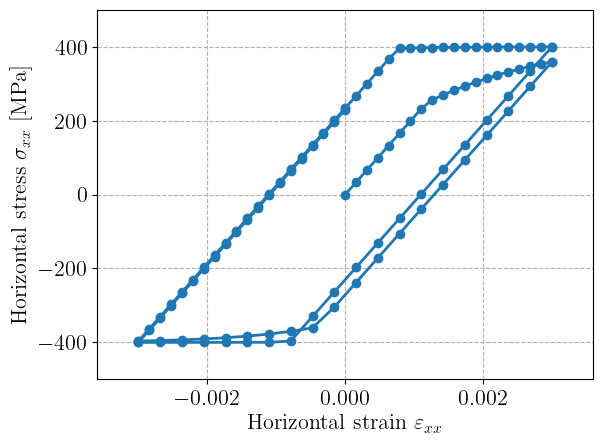

In [16]:
import matplotlib.pyplot as plt
plt.plot(eps_list, Sxx*1e-6, '-o')
plt.xlabel(r"Horizontal strain $\varepsilon_{xx}$")
plt.ylabel(r"Horizontal stress $\sigma_{xx}$ [MPa]")
plt.xlim(-1.2*eps_max, 1.2*eps_max)
plt.ylim(-500, 500)
plt.show()